In [31]:
#!pip install pandas

In [10]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-04-13 11:11:17,324: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [11]:
df = pd.read_csv('sentiment_tweets - Copy1.csv')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           10314 non-null  int64  
 1   Tweet_Content   10314 non-null  object 
 2   negative_score  10314 non-null  float64
 3   positive_score  10314 non-null  float64
 4   neutral_score   10314 non-null  float64
 5   compound_score  10314 non-null  float64
 6   label           10314 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 564.2+ KB


In [13]:
df.head()

,index,Tweet_Content,negative_score,positive_score,neutral_score,compound_score,label
0,106,just had a real good moment. i missssssssss hi...,0.0,0.225,0.775,0.4404,0
1,217,is reading manga http://plurk.com/p/mzp1e,0.0,0.000,1.000,0.0000,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0.0,0.000,1.000,0.0000,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0.0,0.121,0.879,0.4404,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0.0,0.000,1.000,0.0000,0


In [14]:
features = df.iloc[:,2:6]
# features = features.iloc[1:]

print(features)
print(features.info())

       negative_score  positive_score  neutral_score  compound_score
0               0.000           0.225          0.775          0.4404
1               0.000           0.000          1.000          0.0000
2               0.000           0.000          1.000          0.0000
3               0.000           0.121          0.879          0.4404
4               0.000           0.000          1.000          0.0000
...               ...             ...            ...             ...
10309           0.106           0.128          0.766          0.1275
10310           0.167           0.113          0.721         -0.2960
10311           0.469           0.131          0.400         -0.7845
10312           0.229           0.338          0.433          0.1950
10313           0.000           0.000          1.000          0.0000

[10314 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 4 columns):
 #   Column          Non-Null Count  D

In [15]:
labels = df['label']
print(labels)

0        0
1        0
2        0
3        0
4        0
        ..
10309    1
10310    1
10311    1
10312    1
10313    1
Name: label, Length: 10314, dtype: int64


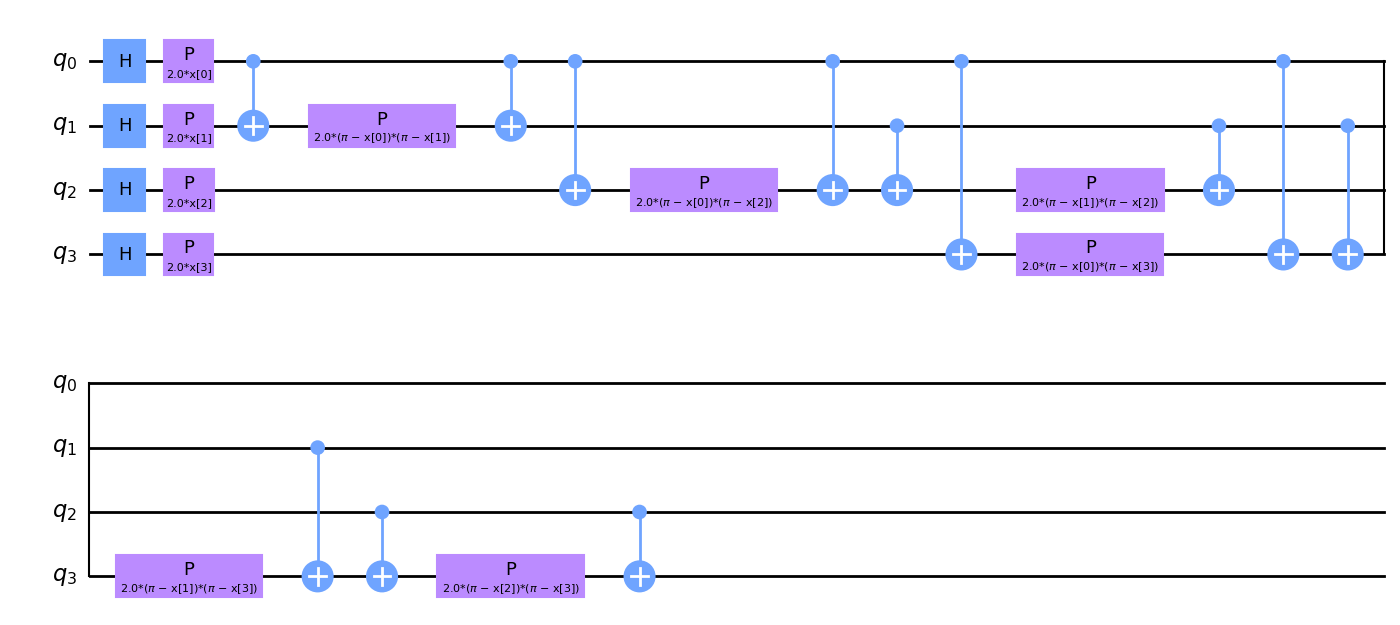

In [16]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

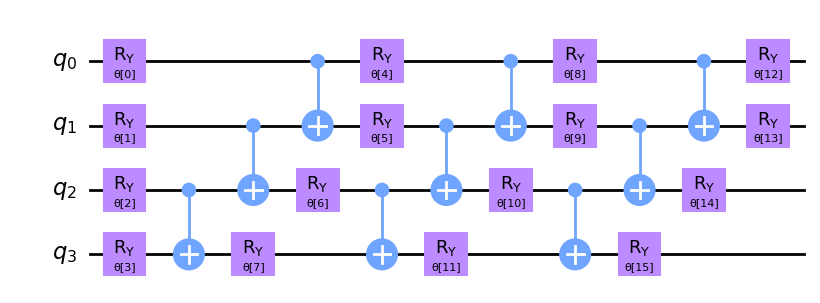

In [17]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [18]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [19]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [20]:
print(type(train_features))
# print(type(train_labels))
train_labels = np.array(train_labels)
print(type(train_labels))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [21]:
print(train_features)
print(train_labels)

      negative_score  positive_score  neutral_score  compound_score
2595           0.000           0.000          1.000          0.0000
2743           0.000           0.336          0.664          0.7644
4986           0.000           0.000          1.000          0.0000
9913           0.142           0.042          0.816         -0.7777
8370           0.393           0.000          0.607         -0.8271
...              ...             ...            ...             ...
9785           0.506           0.000          0.494         -0.8481
7763           0.000           0.238          0.762          0.3612
5218           0.000           0.000          1.000          0.0000
1346           0.000           0.000          1.000          0.0000
3582           0.000           0.143          0.857          0.4574

[8251 rows x 4 columns]
[0 0 0 ... 0 0 0]


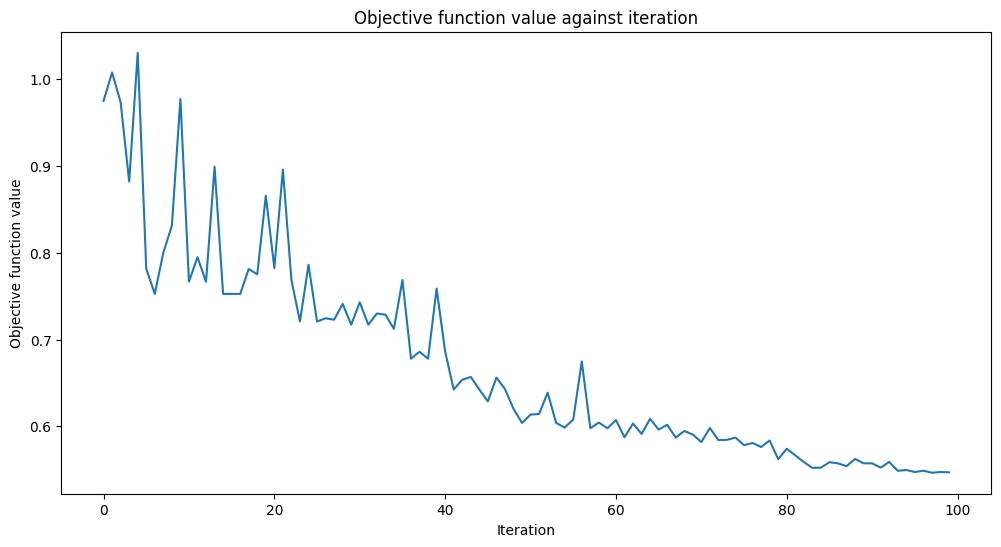

Training time: 8754 seconds
Quantum VQC on the training dataset: 0.88
Quantum VQC on the test dataset:     0.88


In [24]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.primitives import Sampler

import time
from qiskit_machine_learning.algorithms.classifiers import VQC

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    


sampler = Sampler()


vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}" )